In [119]:
import numpy as np
import pandas as pd
import os
import torch
from pathlib import Path
from torchvision.io import read_image
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
from torchvision import models, transforms
import torch.optim as optim
import cv2

In [120]:
class ImageDataset(Dataset):
    def __init__(self, csv_path, img_dir, train, test, transform=None, target_transform=None):
        
        self.img_csv = pd.read_csv(csv_path, usecols = ["img_path", "dist"])
        self.img_dir = img_dir
        self.transform = transforms.Resize([128, 128])
        self.target_transform = (1./30.)


    def __len__(self):
        return len(self.img_csv)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_csv.iloc[idx, 1])
        image = read_image(img_path)[:3,:,:]
        label = self.img_csv.iloc[idx, 0]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = label*self.target_transform
        return image, label

In [121]:
image_dir = ""
annot_path = "output/drone_dataset_28072022011417/data/drone.csv"

In [122]:
annot = pd.read_csv(annot_path, usecols = ["img_path", "dist"]);

In [123]:
dataset = ImageDataset(annot_path, image_dir, train=True, test=False)
trainset,validset,testset = random_split(dataset,
                                         [int(len(dataset)*.65),int(len(dataset)*.15),int(len(dataset)*.20)],
                                         generator=torch.Generator().manual_seed(40))

trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
validloader = DataLoader(validset, batch_size=32, shuffle=True)
testloader = DataLoader(testset, batch_size=32, shuffle=True)

650


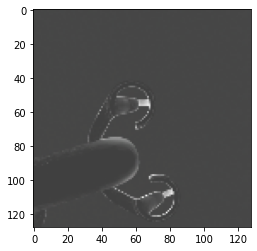

In [124]:
print(len(trainset))
plt.imshow(trainset[3][0].permute(1, 2, 0))

In [135]:
import torch
import torch.nn as nn
from torch.nn import functional

class Model(nn.Module):
    def __init__(self, freeze_resnet = False):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 2, 3, stride=1, padding=0)
        self.conv2 = nn.Conv2d(2, 1, 3, stride=1, padding=0)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(900, 300)
        self.fc2 = nn.Linear(300, 30)
        self.fc3 = nn.Linear(30, 1)

    def forward(self, x):
        x = self.pool(functional.relu(self.conv1(x)))
        x = self.pool(functional.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = functional.relu(self.fc1(x))
        x = functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [146]:
def validation(model, validloader, criterion):
    
    val_loss = 0
    accuracy = 0
    
    for images, labels in iter(validloader):

        images, labels = images.to('cuda'), labels.to('cuda')

        output = model.forward(images.type(torch.float))
        val_loss += criterion(output.type(torch.float), labels.type(torch.float)).item()
        
        print(output)
        probabilities = torch.exp(output)
#         print(probabilities)
        print(labels.data)
        print(output.max(dim=1)[1])
        print(probabilities.max(dim=1)[1])
        
        equality = (labels.data == probabilities.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
    
    return val_loss, accuracy

In [147]:
def train_classifier():
    
    epochs = 20
    steps = 0
    print_every = 16

    model.to('cuda')

    for e in range(epochs):

        model.train()

        running_loss = 0

        for images, labels in iter(trainloader):

            steps += 1

            images, labels = images.to('cuda'), labels.to('cuda')

            optimizer.zero_grad()
            output = model.forward(images.float())
            loss = criterion(output.float(), labels.float())
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if steps % print_every == 0:

                model.eval()

                # Turn off gradients for validation, saves memory and computations
                with torch.no_grad():
                    validation_loss, accuracy = validation(model, validloader, criterion)

                print("Epoch: {}/{}.. ".format(e+1, epochs),
                      "Training Loss: {:.3f}.. ".format(running_loss/print_every),
                      "Validation Loss: {:.3f}.. ".format(validation_loss/len(validloader)),
                      "Validation Accuracy: {:.3f}".format(accuracy/len(validloader)))

                running_loss = 0
                model.train()

In [148]:
model = Model()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_classifier()

tensor([[0.1287],
        [0.1451],
        [0.5059],
        [0.3281],
        [0.0996],
        [0.0524],
        [0.5370],
        [0.2506],
        [0.1551],
        [0.3059],
        [0.1223],
        [0.1026],
        [0.3329],
        [0.1741],
        [0.2814],
        [0.0581],
        [0.1705],
        [0.1287],
        [0.1262],
        [0.1968],
        [0.1418],
        [0.3233],
        [0.0888],
        [0.1198],
        [0.2882],
        [0.3137],
        [0.1853],
        [0.2617],
        [0.2573],
        [0.2804],
        [0.3857],
        [0.1426]], device='cuda:0')
tensor([0.8570, 0.8673, 0.4422, 0.4295, 0.8340, 0.5142, 0.8260, 0.7579, 0.6683,
        0.3215, 0.7126, 0.3606, 0.5088, 0.8505, 0.3350, 0.9894, 0.9110, 0.7141,
        0.7157, 0.8750, 0.5260, 0.6823, 0.6074, 0.5508, 0.5869, 0.5099, 0.4784,
        0.7557, 0.5508, 0.8035, 0.3145, 0.7454], device='cuda:0',
       dtype=torch.float64)
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

tensor([[0.6701],
        [0.5433],
        [0.9908],
        [0.4712],
        [0.3888],
        [1.2084],
        [1.0256],
        [0.7087],
        [0.9278],
        [1.3140],
        [0.8435],
        [0.7376],
        [0.9230],
        [0.8429],
        [0.7917],
        [0.5084],
        [0.7204],
        [0.9092],
        [0.5070],
        [0.5581],
        [0.6369],
        [0.5349],
        [0.7817],
        [0.4123],
        [0.6157],
        [0.7387],
        [0.6991],
        [0.6541],
        [0.5331],
        [0.7122],
        [0.1484],
        [0.9241]], device='cuda:0')
tensor([0.7446, 0.9292, 0.5088, 0.6574, 0.6815, 0.8807, 0.7579, 0.7623, 0.7958,
        0.5088, 0.5907, 0.3606, 0.4497, 0.8360, 0.7557, 0.5142, 0.4460, 0.6650,
        0.9006, 0.8673, 0.7000, 0.8090, 0.6944, 0.9201, 0.8641, 0.5099, 0.6683,
        0.8062, 0.7219, 0.8750, 0.9916, 0.4830], device='cuda:0',
       dtype=torch.float64)
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

KeyboardInterrupt: 

In [ ]:
def test_accuracy(model, testloader):

    # Do validation on the test set
    model.eval()
    model.to('cuda')

    with torch.no_grad():
    
        accuracy = 0
    
        for images, labels in iter(testloader):
    
            images, labels = images.to('cuda'), labels.to('cuda')
    
            output = model.forward(images)

            probabilities = torch.exp(output)
        
            equality = (labels.data == probabilities.max(dim=1)[1])
        
            accuracy += equality.type(torch.FloatTensor).mean()
        
        print("Test Accuracy: {}".format(accuracy/len(testloader))) 